<a href="https://colab.research.google.com/github/Heba2424/Traffic_Light_Detection/blob/main/Traffic__Light_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install ultralytics --quiet
!pip install clearml --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.2/800.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.9 MB/s eta 0:00:00


In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/Yolov8s5e

In [ ]:
import requests
import os
import zipfile

# Function to download file from Dropbox
def download_file(url, save_name):
    if not os.path.exists(save_name):
        # Modify the URL to make it a direct download link
        direct_download_url = url.replace("dl=0", "dl=1")
        file = requests.get(direct_download_url)
        open(save_name, 'wb').write(file.content)

# Download the file from Dropbox
dropbox_url = 'https://www.dropbox.com/scl/fi/fsljj97eyniohackasvi5/Traffic-Light-Detection.v2i.yolov8.zip?rlkey=b0ad41cmso07r2s0lorzobjuf&st=bedw8isl&dl=0'
save_name = '/content/drive/MyDrive/Yolov8s5e/traffic_dataset_v8.zip'
download_file(dropbox_url, save_name)

# Function to unzip the downloaded file
def unzip(zip_file):
    try:
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall('/content/drive/MyDrive/Yolov8s5e')
        print("Extraction successful.")
    except Exception as e:
        print(f"Error extracting '{zip_file}': {str(e)}")

# Unzip the downloaded file
unzip(save_name)


Extraction successful.


In [ ]:
%cd ..

/


In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

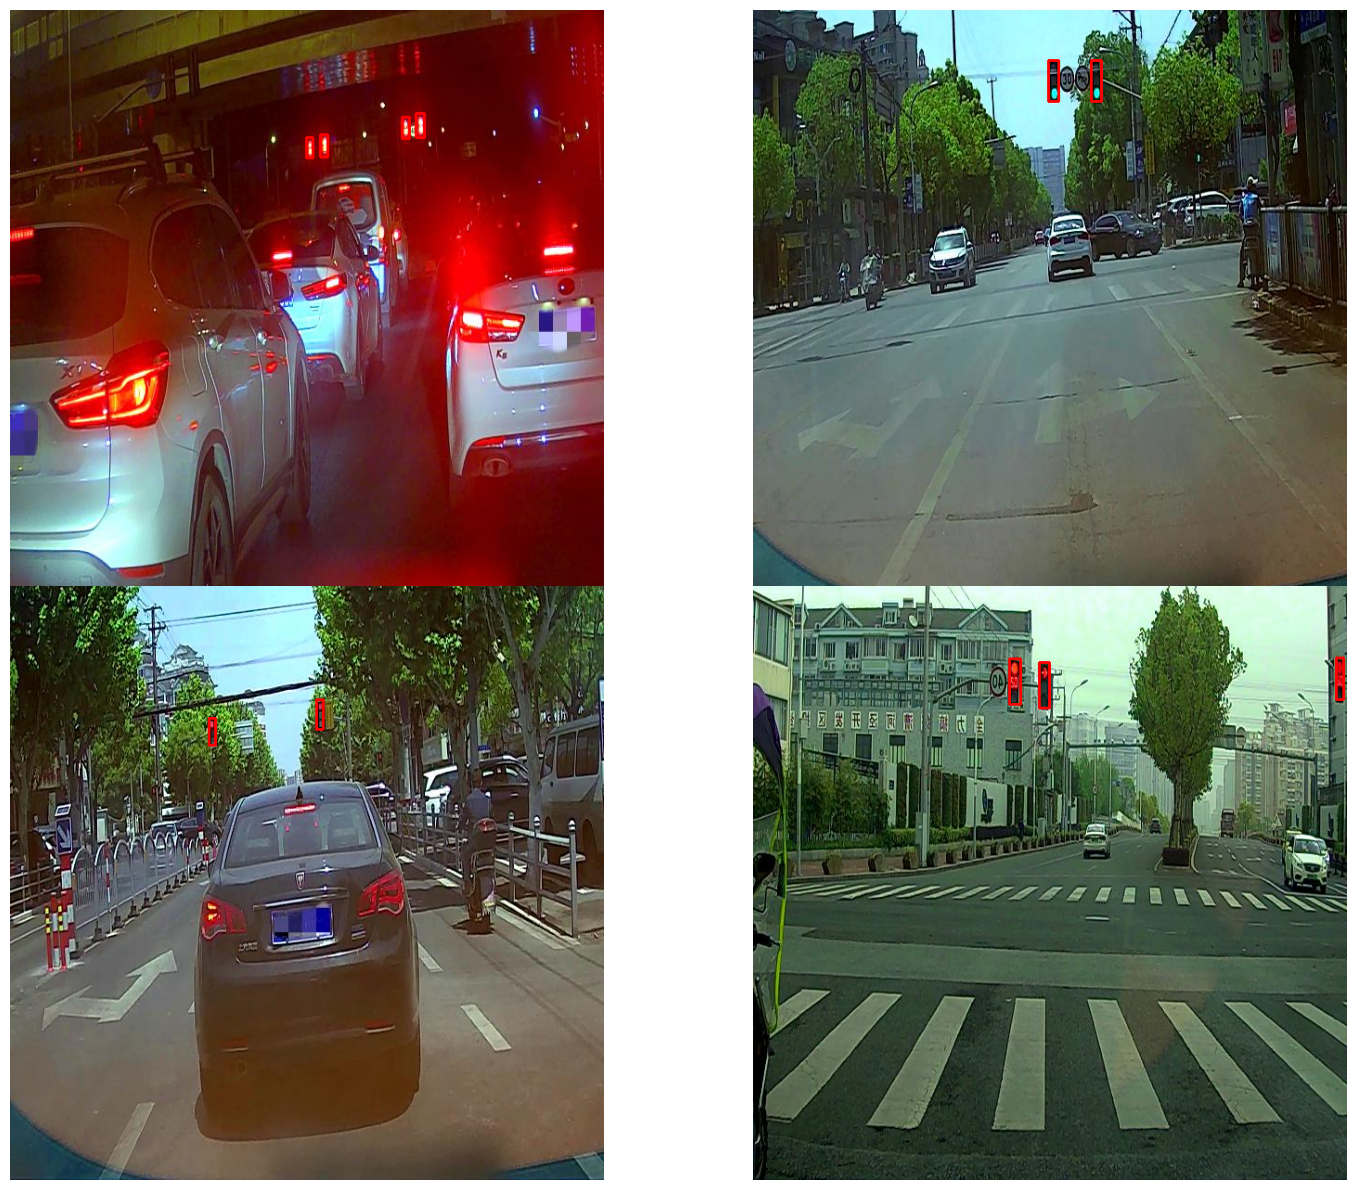

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/drive/MyDrive/Yolov8s5e/train/images',
    label_paths='/content/drive/MyDrive/Yolov8s5e/train/labels',
    num_samples=4,
)

In [ ]:

# Define paths to your dataset directories
train_path = '/content/drive/MyDrive/Yolov8s5e/train'
val_path = '/content/drive/MyDrive/Yolov8s5e/valid'
test_path = '/content/drive/MyDrive/Yolov8s5e/test'

# Define the content of your dataset.yaml file
yaml_content = f"""
train: {train_path}
val: {val_path}
test: {test_path}
nc: 4
names: ['green', 'off', 'red', 'yellow']
"""

# Write the YAML content to a file named dataset.yaml
with open('/content/drive/MyDrive/Yolov8s5e/dataset.yaml', 'w') as f:
    f.write(yaml_content)

# Verify the content of dataset.yaml
!cat /content/drive/MyDrive/Yolov8s5e/dataset.yaml



train: /content/drive/MyDrive/Yolov8s5e/train
val: /content/drive/MyDrive/Yolov8s5e/valid
test: /content/drive/MyDrive/Yolov8s5e/test
nc: 4
names: ['green', 'off', 'red', 'yellow']


In [ ]:
# Sample training for 8 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8s.pt imgsz=1280 data='/content/drive/MyDrive/Yolov8s5e/dataset.yaml' epochs={EPOCHS} batch=8 name=/content/drive/MyDrive/Yolov8s5e/runs


100% 21.5M/21.5M [00:00<00:00, 229MB/s]
Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Yolov8s5e/dataset.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=runs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False,

In [ ]:
import os

# Directory where the weights should be saved
weights_dir = 'runs/detect/yolov8n_v8_50e/weights'

# Check if the directory exists
if os.path.exists(weights_dir):
    # List the files in the directory
    files = os.listdir(weights_dir)
    print(f"Files in {weights_dir}: {files}")
else:
    print(f"Directory not found: {weights_dir}")


Directory not found: runs/detect/yolov8n_v8_50e/weights


In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/Yolov8s5e/runs/weights/best.pt name=/content/drive/MyDrive/Yolov8s5e/yolov8s_eval data='/content/drive/MyDrive/Yolov8s5e/dataset.yaml' imgsz=1280


Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/Yolov8s5e/valid/labels.cache... 931 images, 0 backgrounds, 0 corrupt: 100% 931/931 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 59/59 [00:51<00:00,  1.14it/s]
                   all        931       2379      0.938      0.941      0.971      0.643
                 green        487        953      0.922       0.97      0.982      0.654
                   off         72        114      0.917      0.871      0.946      0.571
                   red        594       1283      0.946      0.976      0.986      0.676
                yellow         17         29      0.965      0.948      0.971       0.67
Speed: 3.1ms preprocess, 34.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive

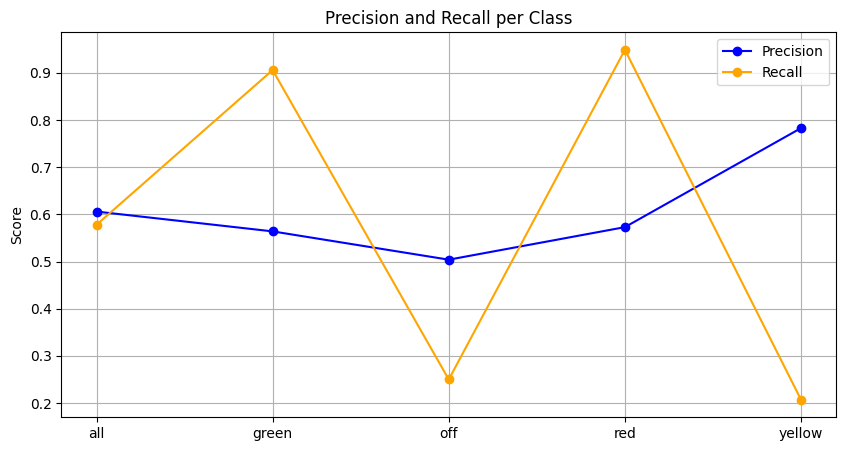

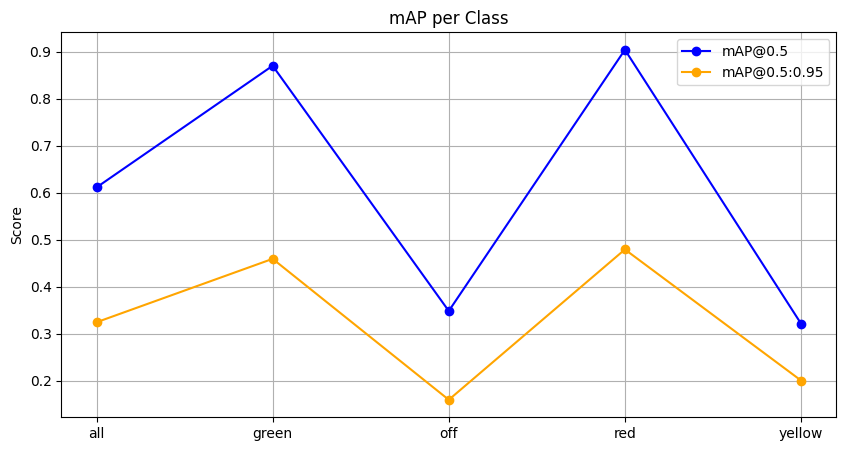

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics from your output
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Plot Precision and Recall
plt.figure(figsize=(10, 5))
plt.plot(classes, precision, marker='o', label='Precision', color='blue')
plt.plot(classes, recall, marker='o', label='Recall', color='orange')
plt.title('Precision and Recall per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP
plt.figure(figsize=(10, 5))
plt.plot(classes, map50, marker='o', label='mAP@0.5', color='blue')
plt.plot(classes, map50_95, marker='o', label='mAP@0.5:0.95', color='orange')
plt.title('mAP per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


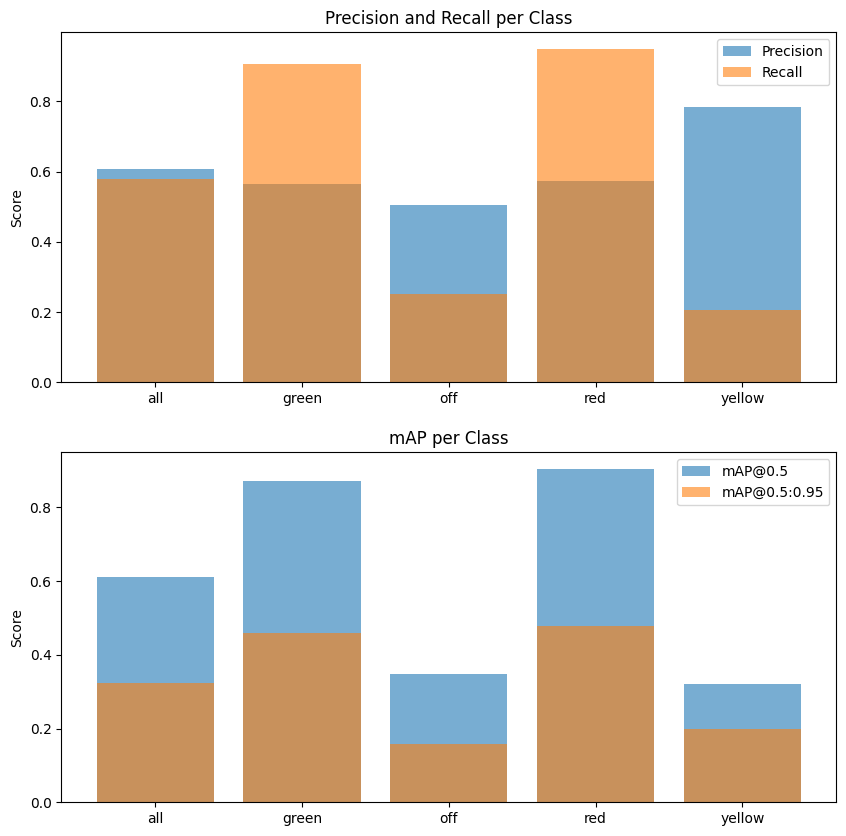

In [ ]:
import matplotlib.pyplot as plt

# Metrics for each class
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Precision and Recall
ax[0].bar(classes, precision, alpha=0.6, label='Precision')
ax[0].bar(classes, recall, alpha=0.6, label='Recall')
ax[0].set_title('Precision and Recall per Class')
ax[0].set_ylabel('Score')
ax[0].legend()

# mAP
ax[1].bar(classes, map50, alpha=0.6, label='mAP@0.5')
ax[1].bar(classes, map50_95, alpha=0.6, label='mAP@0.5:0.95')
ax[1].set_title('mAP per Class')
ax[1].set_ylabel('Score')
ax[1].legend()

plt.show()


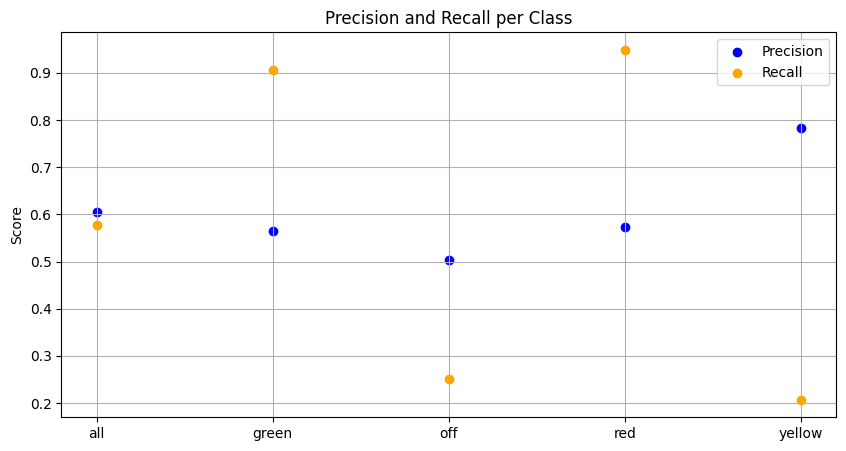

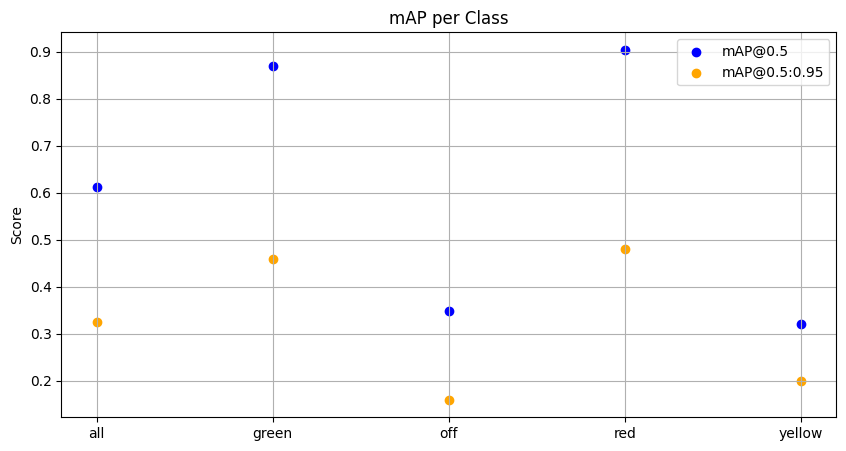

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics from your output
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Plot Precision and Recall
plt.figure(figsize=(10, 5))
plt.scatter(classes, precision, label='Precision', color='blue')
plt.scatter(classes, recall, label='Recall', color='orange')
plt.title('Precision and Recall per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP
plt.figure(figsize=(10, 5))
plt.scatter(classes, map50, label='mAP@0.5', color='blue')
plt.scatter(classes, map50_95, label='mAP@0.5:0.95', color='orange')
plt.title('mAP per Class')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


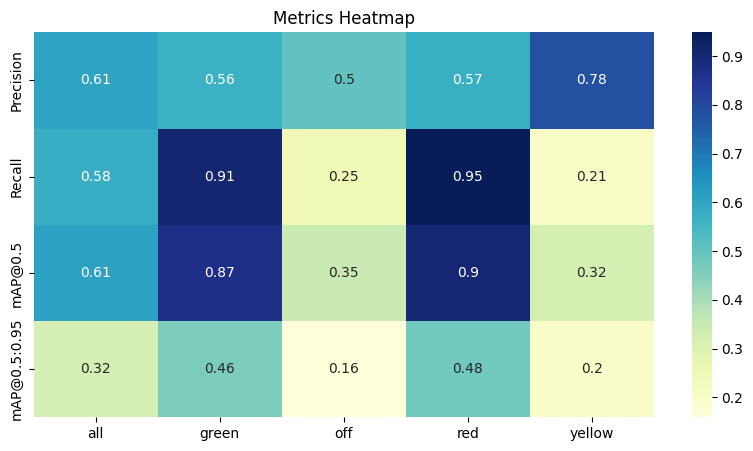

In [ ]:
import seaborn as sns
import numpy as np

# Define the metrics from your output
classes = ['all', 'green', 'off', 'red', 'yellow']
precision = [0.606, 0.564, 0.504, 0.573, 0.783]
recall = [0.578, 0.906, 0.25, 0.949, 0.207]
map50 = [0.611, 0.87, 0.348, 0.904, 0.321]
map50_95 = [0.324, 0.459, 0.159, 0.479, 0.2]

# Create a matrix of metrics
metrics = np.array([precision, recall, map50, map50_95])

# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(metrics, annot=True, cmap="YlGnBu", xticklabels=classes, yticklabels=['Precision', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95'])
plt.title('Metrics Heatmap')
plt.show()


In [ ]:
import cv2
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('/content/drive/MyDrive/Yolov8s5e/runs/weights/best.pt')  # Ensure you have the correct path to the YOLOv8 weights

# Define a mapping from class names to colors
color_map = {
    'red': (0, 0, 255),       # Red color
    'green': (0, 255, 0),     # Green color
    'yellow': (0, 255, 255),  # Yellow color
    'off': (128, 128, 128)    # Gray color
}

# Open video file or capture from camera
video_path = '/content/drive/MyDrive/video 1.mp4'
print(f"Trying to open video file at path: {video_path}")

cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error opening video file. Please check the file path and format.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object to save the video
out = cv2.VideoWriter('/content/output_video_e5.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform detection
    results = model(frame)

    # Annotate the frame
    for detection in results[0].boxes:
        x1, y1, x2, y2 = detection.xyxy[0]
        conf = detection.conf[0]
        cls = detection.cls[0]
        label = model.names[int(cls)]

        # Determine the bounding box color based on the label
        bbox_color = color_map.get(label, (255, 255, 255))  # Default to white if label not in color_map

        # Draw bounding box
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), bbox_color, 2)

        # Put label
        cv2.putText(frame, f'{label} {conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 2)

    # Write the frame to the output video
    out.write(frame)

# Release video objects
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing complete. Output saved to /content/output_video.mp4")


Trying to open video file at path: /content/drive/MyDrive/video 1.mp4

0: 736x1280 3 greens, 104.3ms
Speed: 13.5ms preprocess, 104.3ms inference, 699.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.5ms
Speed: 10.6ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.5ms
Speed: 11.5ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.5ms
Speed: 9.1ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.5ms
Speed: 8.7ms preprocess, 29.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.4ms
Speed: 9.3ms preprocess, 29.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.4ms
Speed: 8.9ms preprocess, 29.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 greens, 29.4

In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install ultralytics --quiet
!pip install clearml --quiet

In [ ]:
!pip install --upgrade gradio --quiet
!pip install pyngrok --quiet

In [ ]:
import gradio as gr
import cv2
from ultralytics import YOLO
from pyngrok import ngrok

# Load YOLOv8 model
model = YOLO('/content/drive/MyDrive/Yolov8s7e/runs/weights/best.pt')  # Ensure you have the correct path to the YOLOv8 weights

# Define a mapping from class names to colors
color_map = {
    'red': (0, 0, 255),       # Red color
    'green': (0, 255, 0),     # Green color
    'yellow': (0, 255, 255),  # Yellow color
    'off': (128, 128, 128)    # Gray color
}

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return "Error opening video file. Please check the file path and format."

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    out = cv2.VideoWriter('/content/output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)

        for detection in results[0].boxes:
            x1, y1, x2, y2 = detection.xyxy[0]
            conf = detection.conf[0]
            cls = detection.cls[0]
            label = model.names[int(cls)]

            bbox_color = color_map.get(label, (255, 255, 255))

            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), bbox_color, 2)
            cv2.putText(frame, f'{label} {conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 2)

        out.write(frame)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return '/content/output_video.mp4'

iface = gr.Interface(
    fn=process_video,
    inputs=gr.Video(label="Upload a Video"),
    outputs=gr.Video(label="Processed Video"),
    title="Traffic Light Detection",
    description="Upload a video to detect and highlight traffic lights with different bounding box colors based on the light's color."
)

# Install ngrok authtoken
ngrok.set_auth_token("2j7RBQQIROQNWeTiaq56wnw5sY8_2Qtk5vtnnFcyQZ3wA7BN8")  # Replace with your ngrok authtoken

# Create a tunnel to the Gradio interface
public_url = ngrok.connect(7861)
print(f'Public URL: {public_url}')

iface.launch()
